=== A. Prognozowanie Liczby Klientów ===
Trening modelu prognozującego...


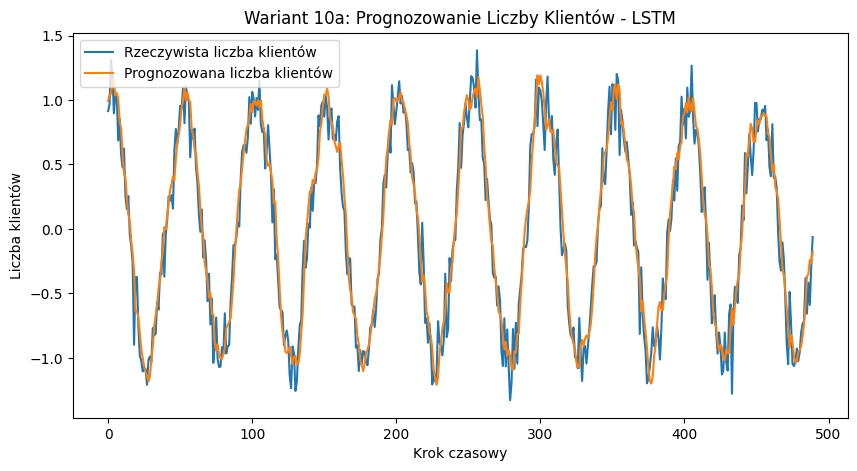


=== B. Wykrywanie Anomalii w Danych z Monitoringu ===
Trening modelu wykrywającego anomalie...
Dokładność wykrywania anomalii w danych z monitoringu: 1.00

=== C. Rozpoznawanie Wzorców Wejść i Wyjść Klientów ===
Trening modelu rozpoznającego wzorce...
Dokładność klasyfikacji wzorców wejść/wyjść: 1.00


In [ ]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# FUNKCJE GENERUJĄCE DANE SYNTETYCZNE

def generate_forecasting_data(n_samples=1000, freq=0.05, noise=0.1):
    """1. Generuje dane do prognozowania (np. Liczba Klientów)"""
    x = np.arange(n_samples)
    y = np.sin(2 * np.pi * freq * x) + np.random.normal(0, noise, size=n_samples)
    return y.reshape(-1, 1)

def generate_anomaly_data(n_samples=1000, timesteps=20, anomaly_rate=0.08):
    """2. Generuje dane z anomaliami (np. Monitoring)"""
    X = np.random.normal(0, 1, (n_samples, timesteps))
    y = np.zeros(n_samples)
    n_anomalies = int(anomaly_rate * n_samples)
    anomalies = np.random.choice(n_samples, n_anomalies, replace=False)
    # Dodanie dużej wartości do anomalii
    X[anomalies] += np.random.normal(5, 1, (n_anomalies, timesteps))
    y[anomalies] = 1
    return X.reshape(n_samples, timesteps, 1), y

def generate_pattern_data(n_classes=3, samples_per_class=500, timesteps=30):
    """3. Generuje dane z wzorcami czasowymi (np. Wzorce Wejść/Wyjść Klientów)"""
    X, y = [], []
    for cls in range(n_classes):
        for _ in range(samples_per_class):
            if cls == 0:
                # Klasa 0: Krótka interakcja
                seq = np.random.normal(0, 0.2, timesteps)
            elif cls == 1:
                # Klasa 1: Typowa interakcja
                seq = np.sin(np.linspace(0, 3 * np.pi, timesteps)) + np.random.normal(0, 0.1, timesteps)
            else:
                # Klasa 2: Długa interakcja
                seq = np.sin(np.linspace(0, 6 * np.pi, timesteps)) + np.random.normal(0, 0.2, timesteps)
            X.append(seq)
            y.append(cls)
    X = np.array(X).reshape(-1, timesteps, 1)
    y = tf.keras.utils.to_categorical(y, num_classes=n_classes)
    return X, y

def create_dataset(dataset, look_back=10):
    """Funkcja pomocnicza do tworzenia sekwencji dla prognozowania"""
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# A. PROGNOZOWANIE LICZBY KLIENTÓW W PUNKCIE USŁUGOWYM

print("=== A. Prognozowanie Liczby Klientów ===")
data = generate_forecasting_data(n_samples=500, freq=0.02, noise=0.15)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
look_back = 10
X_prognoza, y_prognoza = create_dataset(data_scaled, look_back)
X_prognoza = np.reshape(X_prognoza, (X_prognoza.shape[0], X_prognoza.shape[1], 1))

model_prognoza = Sequential()
model_prognoza.add(LSTM(50, input_shape=(look_back, 1)))
model_prognoza.add(Dense(1))
model_prognoza.compile(optimizer='adam', loss='mean_squared_error')

print("Trening modelu prognozującego...")
model_prognoza.fit(X_prognoza, y_prognoza, epochs=20, batch_size=1, verbose=0)

predicted = model_prognoza.predict(X_prognoza, verbose=0)
predicted = scaler.inverse_transform(predicted)

plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(y_prognoza.reshape(-1, 1)), label='Rzeczywista liczba klientów')
plt.plot(predicted, label='Prognozowana liczba klientów')
plt.title('Wariant 10a: Prognozowanie Liczby Klientów - LSTM')
plt.xlabel('Krok czasowy')
plt.ylabel('Liczba klientów')
plt.legend()
plt.show()

# B. WYKRYWANIE ANOMALII W DANYCH Z MONITORINGU

print("\n=== B. Wykrywanie Anomalii w Danych z Monitoringu ===")
X_anomalia, y_anomalia = generate_anomaly_data(n_samples=1000, timesteps=20, anomaly_rate=0.08)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_anomalia, y_anomalia, test_size=0.2, random_state=42)

model_anomalia = Sequential()
model_anomalia.add(LSTM(32, input_shape=(X_anomalia.shape[1], 1)))
model_anomalia.add(Dense(1, activation='sigmoid'))
model_anomalia.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Trening modelu wykrywającego anomalie...")
model_anomalia.fit(X_train_a, y_train_a, epochs=10, batch_size=32, validation_data=(X_test_a, y_test_a), verbose=0)

loss, accuracy = model_anomalia.evaluate(X_test_a, y_test_a, verbose=0)
print(f"Dokładność wykrywania anomalii w danych z monitoringu: {accuracy:.2f}")

# C. ROZPOZNAWANIE WZORCÓW WEJŚĆ I WYJŚĆ KLIENTÓW

print("\n=== C. Rozpoznawanie Wzorców Wejść i Wyjść Klientów ===")
X_wzorce, y_wzorce = generate_pattern_data(n_classes=3, samples_per_class=500, timesteps=30)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wzorce, y_wzorce, test_size=0.2, random_state=42)

model_wzorce = Sequential()
model_wzorce.add(LSTM(64, input_shape=(X_wzorce.shape[1], 1)))
model_wzorce.add(Dense(3, activation='softmax'))
model_wzorce.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Trening modelu rozpoznającego wzorce...")
model_wzorce.fit(X_train_w, y_train_w, epochs=15, batch_size=32, validation_data=(X_test_w, y_test_w), verbose=0)

loss, accuracy = model_wzorce.evaluate(X_test_w, y_test_w, verbose=0)
print(f"Dokładność klasyfikacji wzorców wejść/wyjść: {accuracy:.2f}")